In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 31 11:28:58 2019

@author: DEPAGRA
"""
import os
import libdtw as lib
from tqdm import tqdm, tqdm_notebook
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import multiprocessing
from joblib import Parallel, delayed
from collections import defaultdict
import ast

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [1]:
N_DATA = 200
data = lib.load_data(N_DATA)
step_pattern = 'symmetricP2'

D = lib.Dtw(data)

#with open('dtwObjOptWeights16AllFeats.pickle', 'rb') as f:
 #   D_weights = pickle.load(f)
#D.data['feat_weights'] = D_weights

try:
    with open('data/all_sub%s_%s.pickle'%(N_DATA, step_pattern), 'rb') as f:
        D.data_open_ended['warp_dist'] = pickle.load(f)
except OSError as ex:
    for _id in tqdm_notebook(D.data['queriesID']):
        D.call_dtw(_id, step_pattern=step_pattern, n_jobs=1, open_ended=True, all_sub_seq=True)

    with open('data/all_sub%s_%s.pickle'%(N_DATA, step_pattern), 'wb') as f:
        pickle.dump(D.data_open_ended['warp_dist'], f, protocol=pickle.HIGHEST_PROTOCOL)

class Estimator:
    
    def __init__(self, dtw_obj=D, regressor=LinearRegression(), loss='coxph', learning_rate=0.1, n_estimators=100, max_depth=3, subsample=1.0, random_state=42):
        np.random.seed(random_state)
        self.regressor = regressor
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subsample = subsample
        self.random_state = random_state
        
        
        self.dtw_obj = dtw_obj
        
    def fit(self, x_train, y_train):
        self.model = GradientBoostingSurvivalAnalysis(loss=self.loss,
                                                 learning_rate = self.learning_rate,
                                                 n_estimators=self.n_estimators,
                                                 max_depth=self.max_depth,
                                                 subsample=self.subsample,
                                                 random_state = self.random_state)
        
        self.x_train = x_train
        self.y_train = y_train
        
        self.model.fit(self.x_train, self.y_train)
        
        self.data_set = pd.concat([self.x_train, pd.Series(data=self.y_train['time_remaining'], index=self.x_train.index, name='time_remaining')], axis=1, sort = False)
        self.data_set['risk'] = self.model.predict(self.x_train)
        
        return self
    
    def predict(self, new_x, by='risk'):
        x_new = pd.DataFrame(deepcopy(new_x))
        x_new['risk'] = self.model.predict(x_new)
        query_id = list(x_new.index)[0]
        x_length = len(self.dtw_obj.data['queries'][query_id][0]['values'])
        x_new['time_remaining'] = x_length -x_new['length']
        
        self.data_set_extd = pd.concat([self.data_set, x_new], axis = 0, sort = False)
        self.data_set_extd.sort_values(by='risk', ascending=False, inplace=True)

        locations = self.data_set_extd.index.get_loc(query_id)
        
        locs = list()
        if type(locations) == slice:
            start, stop = locations.start, locations.stop
            locs.extend([loc for loc in np.arange(start, stop)])
        elif type(locations) == int or type(locations) == np.int64:
            locs = [locations]
        elif type(locations) == np.ndarray:
            locs = np.arange(len(locations))[locations]
        else:
            print('ERROR')
            print(type(locations))
            locs = []
          
        y_values = self.data_set_extd['time_remaining']
        
        if by == 'rank':
            x_values = pd.Series(np.arange(y_values))
        elif by == 'risk':
            x_values = self.data_set_extd['risk']
        elif by == 'scaled_risk':
            scaler = MinMaxScaler()
            x_values = scaler.fit_transform(self.data_set_extd['risk'])
        ests = list()
        
        for loc in locs:
#            print(locs)
#            print([x for x, y in zip(np.arange(len(t_left)), t_left.values)])
            xy = [(x,y) for (x, y) in zip(x_values.values, y_values.values) if x != loc]
            x = np.array([x[0] for x in xy]).reshape(-1,1)
            y = np.array([x[1] for x in xy])
        ## Add possibility for risk as X variable
            reg = self.regressor.fit(X=x, y=y)
            if by == 'scaled_risk':
                ests.append(reg.predict(scaler.transform(x_values.values[loc]))[0])
            else:
                ests.append(reg.predict(x_values.values[loc])[0])
            
        return np.array(ests)
    
    def score(self, x_test, y_test):
        y_pred = self.predict(x_test)
        return np.mean(np.abs(y_pred - y_test['time_remaining']))
    
    def get_params(self, deep=True):
        return {'dtw_obj': self.dtw_obj,
                'regressor': self.regressor,
                'loss': self.loss,
                'learning_rate': self.learning_rate,
                'n_estimators': self.n_estimators,
                'max_depth': self.max_depth,
                'subsample': self.subsample}

    def set_params(self, parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

            
def cv_splitter(data_set):
    for query_id in data_set.index.unique():
        train_id = data_set.loc[data_set.index != query_id, :].index
        test_id = data_set.loc[data_set.index == query_id, :].index
        
        train_loc = list()
        for _id in train_id.unique():
            locs = data_set.index.get_loc(_id)
            if type(locs) == slice:
                start, stop = locs.start, locs.stop
                train_loc.extend([[loc] for loc in np.arange(start, stop)])
            elif type(locs) == int or type(locs) == np.int64:
                train_loc.append([locs])
            else: print('\n', locs, type(locs))
       
        if type(data_set.index.get_loc(query_id)) == slice:
            locs = data_set.index.get_loc(query_id)
            start, stop = locs.start, locs.stop
            test_loc = [[loc] for loc in np.arange(start, stop)]
        elif type(data_set.index.get_loc(query_id)) == int or type(data_set.index.get_loc(query_id)) == np.int64:
            test_loc = [data_set.index.get_loc(query_id)]
        else: print('ERROR 2')
        
        yield((train_id.unique(), test_id.unique(), train_loc, test_loc))
        
def build_structured_array(data_set):
    output = list()
    for idx, row in data_set.iterrows():
        survival_time = row['true_length'] - row['length']
        output.append((True, survival_time))
    res = np.array(output, dtype = [('status', bool), ('time_remaining', 'f8')])
    return res

def generate_dataset_xy(t_ref, D):
    data_set = list()

    for _id, warp_dist in D.data_open_ended['warp_dist'].items():
        mapped_points = list(filter(lambda x: x[0]==t_ref, warp_dist))
        for (i, j, d) in mapped_points:
            data_point = {'DTW_distance': d,
                          'length': j + 1,
                          'query_id' : _id,
                          'true_length': len(data[_id][0]['values'])}
            data_set.append(data_point)
        
    data_set = pd.DataFrame(data_set)
    data_set.index = data_set['query_id']
    
    data_y = build_structured_array(data_set)
    data_set.drop(columns = ['query_id', 'true_length'], inplace = True)

    for _id, row in data_set.iterrows():
        batch = D.data['queries'][_id]
        length = int(row['length'])
        for pv in batch:
            data_set.at[_id, pv['name']] = pv['values'][length - 1]
    
    return (data_set, data_y)

def GridSearch(estimator, dtw_obj, param_grid, n_jobs, cv_splitter=cv_splitter):
    params_iter = ParameterGrid(param_grid)
    ref_len = len(dtw_obj.data['reference'][0]['values'])
    
    score_t = list()
    for t in tqdm_notebook(np.arange(0, ref_len, 1), desc='Time loop'):
        try:
            with open('cv/%s.pickle'%t, 'rb') as f:
                score_params = pickle.load(f)

        except OSError as ex:
            def processCV(train_id, test_id, train_loc, test_loc):
                x_train = data_x.loc[train_id, :]
                #print(x_train.shape)
                y_train = np.array(np.concatenate([data_y[idx] for idx in train_loc], axis=0), dtype = [('status', bool), ('time_remaining', 'f8')])
                #print(y_train.shape, '\n')

                x_test = data_x.loc[test_id, :]
                y_test_raw = [data_y[idx] for idx in test_loc]

                y_test = np.concatenate(y_test_raw, axis=0) if len(y_test_raw)>1 else y_test_raw
                y_test = np.array(y_test, dtype = [('status', bool), ('time_remaining', 'f8')])

                estimator.fit(x_train, y_train)

                score = estimator.score(x_test, y_test)
                return score
                    
            data_x, data_y = generate_dataset_xy(t, dtw_obj)
            score_params = list()
            for parameters in params_iter:#tqdm_notebook(params_iter, desc='Parameter Loop', leave=False):
                estimator.set_params(parameters)
                score_cv = Parallel(verbose = 0, n_jobs = -2)(delayed(processCV)(train_id, test_id, train_loc, test_loc)\
                                                              for (train_id, test_id, train_loc, test_loc) in cv_splitter(data_x))
                

                score_params.append((parameters, t, score_cv))
            with open('cv/%s.pickle'%t, 'wb') as f:
                pickle.dump(score_params, f, protocol=pickle.HIGHEST_PROTOCOL)

        score_t.append(score_params)
        
    return score_t
                
lr = LinearRegression()
tr = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=10, criterion='mae', n_jobs=1)
param_grid = {'regressor': [rf], 
              'loss': ['squared'],
              'learning_rate': [0.01],
              'n_estimators': [200],
              'max_depth': [10],
              'subsample': [0.5]}

estimator = Estimator(dtw_obj=D)

scores = GridSearch(estimator=estimator, dtw_obj=D, param_grid=param_grid, n_jobs=1, cv_splitter=cv_splitter)

#%%

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [2]:
score_dict = dict()
for fn in sorted([file for file in os.listdir('cv/') if not file.startswith('.')], key = lambda x: int(x.split('.')[0]), reverse = False):
    with open('cv/%s'%fn, 'rb') as f:
        single_score = pickle.load(f)
    for triple in single_score:
        par = str(sorted(triple[0].items()))
        t = triple[1]
        avg_score = triple[2]
        if par in score_dict:
            score_dict[par].append(avg_score)
        else:
            score_dict[par] = [avg_score]

In [3]:
scores_rf = list(score_dict.values())[0]

In [8]:
avg_naive_smart = list()
for t in tqdm_notebook(np.arange(415)):
    diff_lenghts = list()
    for query_id in D.data['queriesID']:
        for (i, j, d) in filter(lambda x: x[0] == t, D.data_open_ended['warp_dist'][query_id]):
            now_len = j+1
            set_lenghts = list()
            for _id, warp_dist in D.data_open_ended['warp_dist'].items():
                if _id != query_id:
                    corr_points = list(filter(lambda x: x[0] == t, warp_dist))
                    if corr_points and len(D.data['queries'][_id][0]['values']) > now_len:
                        set_lenghts.append(len(D.data['queries'][_id][0]['values']))
            avg_lenght = np.mean(set_lenghts)
        diff_lenghts.append(np.abs(len(D.data['queries'][query_id][0]['values']) - avg_lenght))
    avg_naive_smart.append(diff_lenghts)
    

with open('avg_naive_smart.pickle', 'wb') as f:
    pickle.dump(avg_naive_smart, f, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
with open('avg_naive_smart.pickle', 'rb') as f:
    avg_naive_smart = pickle.load(f)

In [6]:
avg_naive_smart

[[73.39506172839504,
  104.58641975308643,
  25.098765432098787,
  111.62962962962962,
  52.265432098765416,
  40.19135802469134,
  59.30864197530866,
  61.320987654321016,
  27.111111111111086,
  47.234567901234584,
  32.141975308641975,
  37.17283950617286,
  4.975308641975289,
  12.129629629629619,
  29.234567901234584,
  15.03703703703701,
  95.53086419753089,
  39.296296296296305,
  75.40740740740739,
  95.53086419753089,
  13.135802469135797,
  84.46296296296299,
  61.320987654321016,
  25.098765432098787,
  18.166666666666686,
  81.44444444444446,
  92.51234567901236,
  52.37654320987656,
  13.024691358024711,
  21.074074074074076,
  28.117283950617264,
  11.012345679012356,
  108.61111111111109,
  50.3641975308642,
  11.012345679012356,
  34.15432098765433,
  41.19753086419752,
  5.981481481481467,
  51.37037037037038,
  14.141975308641975,
  78.42592592592592,
  7.993827160493822,
  6.092592592592609,
  54.27777777777777,
  98.54938271604937,
  31.24691358024694,
  17.04938271

In [7]:
plt.plot(pd.Series(avg_naive_smart).fillna(method='ffill').rolling(1).mean().fillna(method='bfill').values)
plt.plot(pd.Series(scores_rf).fillna(method='ffill').rolling(1).mean().fillna(method='bfill').values)
plt.show()

TypeError: cannot handle this type -> object

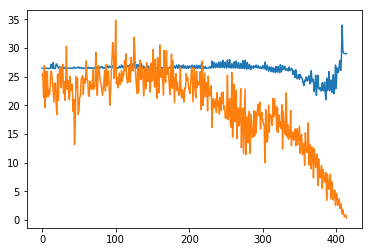

In [6]:
plt.plot(pd.Series(avg_naive_smart).fillna(method='ffill').rolling(1).mean().fillna(method='bfill').values)
plt.plot(pd.Series(scores_rf).fillna(method='ffill').rolling(1).mean().fillna(method='bfill').values)
plt.show()

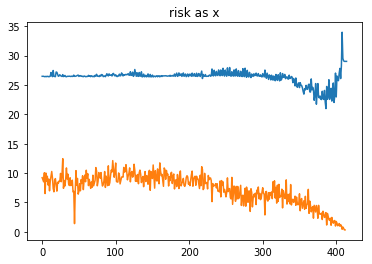

In [27]:
plt.plot(pd.Series(avg_naive_smart).fillna(method='ffill').rolling(1).mean().fillna(method='bfill').values)
plt.plot(pd.Series(scores_rf).fillna(method='ffill').rolling(1).mean().fillna(method='bfill').values)
plt.title('risk as x')
plt.show()

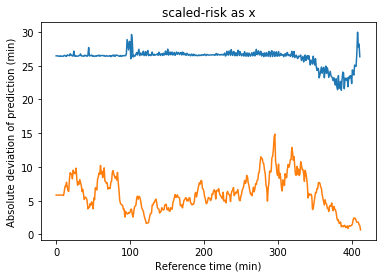

In [26]:
idx = 1
plt.plot(avg_naive_smart)
plt.plot(pd.Series([x[idx] for x in scores_rf]).fillna(method='ffill').rolling(10).mean().fillna(method='bfill').values)
plt.title('scaled-risk as x')
plt.ylabel('Absolute deviation of prediction (min)')
plt.xlabel('Reference time (min)')
plt.show()

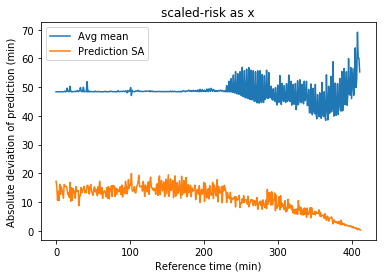

In [18]:
plt.plot([np.mean(x) for x in avg_naive_smart], label = 'Avg mean')
plt.plot([np.mean(x) for x in scores_rf], label = 'Prediction SA')
plt.title('scaled-risk as x')
plt.ylabel('Absolute deviation of prediction (min)')
plt.xlabel('Reference time (min)')
plt.legend()
plt.show()

C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1887: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
C:\Users\DEPAGRA\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1888: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


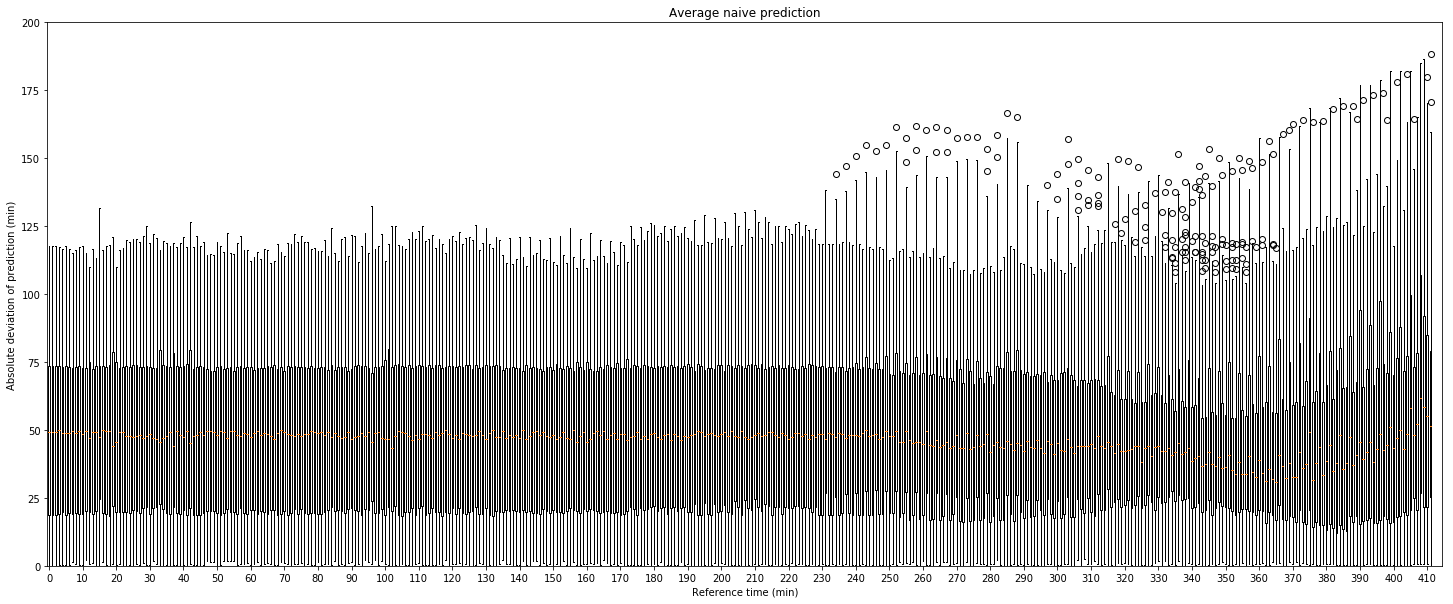

In [8]:
plt.figure(figsize = (25,10))
plt.boxplot(avg_naive_smart)
plt.title('Average naive prediction')
plt.ylabel('Absolute deviation of prediction (min)')
plt.xlabel('Reference time (min)')
plt.xticks(np.arange(1,415,10), np.arange(0,414,10))
plt.ylim((0, 200))
plt.show()

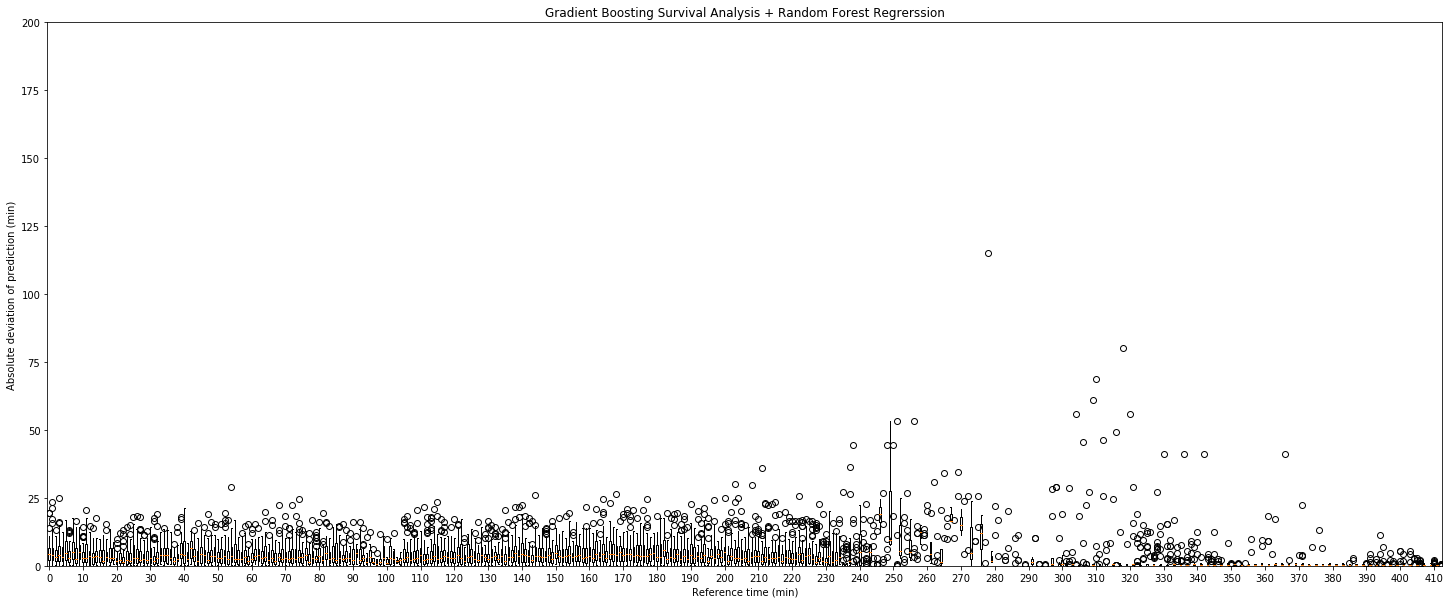

In [9]:
plt.figure(figsize = (25,10))
plt.boxplot(scores_rf)
plt.title('Gradient Boosting Survival Analysis + Random Forest Regrerssion')
plt.ylabel('Absolute deviation of prediction (min)')
plt.xlabel('Reference time (min)')
plt.xticks(np.arange(1,415,10), np.arange(0,414,10))
plt.ylim((0, 200))
plt.show()

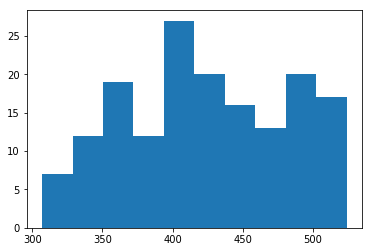

307 524 56.87


In [19]:
lengths = list()
for _id, batch in D.data['queries'].items():
    lengths.append(len(batch[0]['values']))
plt.hist(lengths)
plt.show()
print('Min: %d, min(lengths), max(lengths), %np.std(lengths))